In [515]:
import pandas as pd
import operator as op
from functools import reduce
import numpy as np
pd.set_option("display.max_rows", 101)

1. Import confirmed, recovered and deaths data set for a given country

In [516]:
confirmed = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

2. Pre-process the datasets

In [517]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    index = df.iloc[0].name

    df = df.T
    df = df.rename({index: col_name}, axis = 1)
    # get rid of columns that do not represent the number of recovered/confirmed/deaths 
    df = df.iloc[4:,:]
    
    return df

    #df = df[df[col_name] > 0]


In [518]:
recovered = reformat(recovered, 'Switzerland', 'Recovered cases')
confirmed = reformat(confirmed, 'Switzerland', 'Confirmed cases')
deaths = reformat(deaths, 'Switzerland', 'Deaths cases')

recovered.tail()

,Recovered cases
5/9/20,26400
5/10/20,26600
5/11/20,26800
5/12/20,26800
5/13/20,27100


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [519]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [520]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [521]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

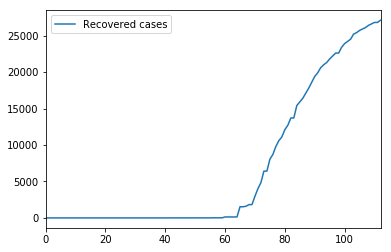

In [522]:
recovered.plot()

[Text(0.5, 0, 'Number of individuals recovered')]

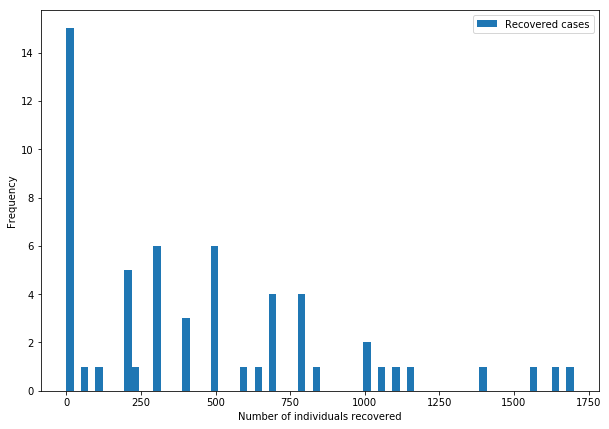

In [523]:
ax = pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot.hist(bins=70,figsize=(10,7))
ax.set(xlabel="Number of individuals recovered")
#pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot.hist(xlabel="Number of Recovered")
#(title="Frequency per number of daily recovered counted since 55th day (March 17th)")#.groupby()
# in order to see zeros from when people started recovering

[Text(0.5, 0, 'Day')]

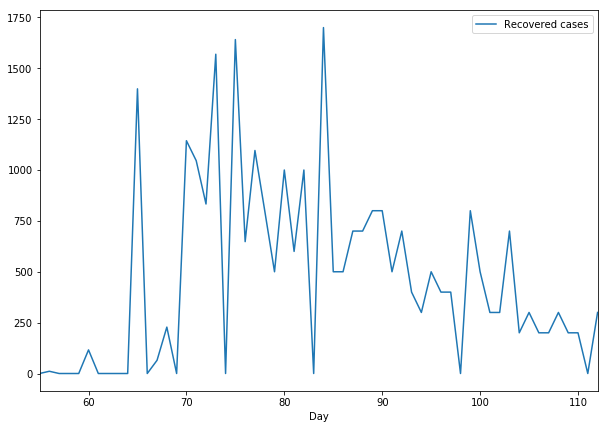

In [524]:
ax = pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot(figsize=(10,7))
ax.set(xlabel='Day')

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [525]:
data = recovered.merge(infected, on='Date')

data['Date'] = pd.to_datetime(data['Date'])
#df['DOB'] = pd.to_datetime(df.DOB)

data = data.set_index('Date')
data['Recovered Daily'] = recovered_daily
data['Deaths Daily'] = deaths_daily

data = data[['Infected Cases', 'Recovered Daily', 'Deaths Daily']]
data.head()

,Infected Cases,Recovered Daily,Deaths Daily
Date,,,
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


## Data Smoothing

For each of 'data''s columns, we will apply the same smoothing

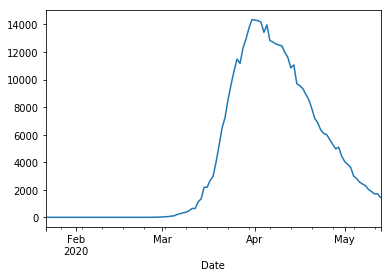

In [526]:
data['Infected Cases'].plot()

We implement the following filters:
- Gaussian filter (even length):  $$\tilde{x}_t= \frac{1}{2^{2K}} \sum_{k=-K}^K \binom{2K}{K+k} \, x_{t-k}$$
- Gaussian filter (odd length) :  $$\tilde{x}_t= \frac{1}{2^{2K+1}} \sum_{k=-K}^{K+1} \binom{2K+1}{K+k} \, x_{t-k}$$

In [527]:
def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [528]:
def gauss_filter(x, K, parity='even'):
    
    # constant
    A = 2*K
    
    #upper bound of sum
    B = K
    
    if parity == 'odd':
        A += 1
        B += 1
        
    const = 1/(2**A)
    
    ret = []
    
    # x elements that will see their value change 
    r_x = np.arange(K, len(x)-K)
    
    # range of k
    r_k = np.arange(-K,B+1)
    
    for i in range(len(x)):
        if i not in r_x:
            ret.append(x[i])
        else: 
            # list on which we will save values to be summed to yield new x_tilde_t
            ls = []
            for k in r_k:
                #x_{t-k}
                comb = ncr(A, K+k)
                #print('i: ',i,'k: ',k)
                x_tk = x[i-k] 
                #print(comb, x_tk, comb*x_tk)
                #print(ls)
                ls.append(int(comb*x_tk*const))
                #print(ls)
            ret.append(np.sum(ls))
    return ret

In [529]:
data['Infected Cases'] = gauss_filter(data['Infected Cases'].values, 1)
data['Recovered Daily'] = gauss_filter(data['Recovered Daily'].values, 2)
data['Deaths Daily'] = gauss_filter(data['Deaths Daily'].values, 2)

## Create X and y to export data

In [530]:
data = data.reset_index()

In [531]:
dataframe = pd.concat([data['Date'],data['Recovered Daily'], data['Deaths Daily'], data['Infected Cases'].shift(7),
                   data['Infected Cases'].shift(8),data['Infected Cases'].shift(9),
                   data['Infected Cases'].shift(10),data['Infected Cases'].shift(11),
                   data['Infected Cases'].shift(12),data['Infected Cases'].shift(13),
                   data['Infected Cases'].shift(14),data['Infected Cases'].shift(15),
                   data['Infected Cases'].shift(16),data['Infected Cases'].shift(17),
                   data['Infected Cases'].shift(18),data['Infected Cases'].shift(19),
                   data['Infected Cases'].shift(20),data['Infected Cases'].shift(21)], axis=1)

In [532]:
dataframe

,Date,Recovered Daily,Deaths Daily,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases,Infected Cases
0,2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-01-27,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-01-28,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-01-29,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01-30,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-01-31,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To go on I think it would be better to have a larger data set

In [533]:
# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]



In [534]:
dataframe = dataframe.set_index('Date')

### Delete first 15 days (noise data)

In [535]:
dataframe_new = dataframe.iloc[15:,:].copy()

In [536]:
y_recovered = dataframe_new['Recovered Daily']
y_deaths = dataframe_new['Deaths Daily']

X = dataframe_new.iloc[:,2:]

In [537]:
X

,Infected cases t-7,Infected cases t-8,Infected cases t-9,Infected cases t-10,Infected cases t-11,Infected cases t-12,Infected cases t-13,Infected cases t-14,Infected cases t-15,Infected cases t-16,Infected cases t-17,Infected cases t-18,Infected cases t-19,Infected cases t-20,Infected cases t-21
Date,,,,,,,,,,,,,,,
2020-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-04,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-05,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,10.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply changes on Dataframe when recovered value equals 0

In [538]:
df = dataframe_new.copy()

In [539]:
# don't forget to round up
recovered = df['Recovered Daily'].reset_index()

for i, el in recovered.iterrows():
    if (i > 24) & (el['Recovered Daily'] == 0):
        mean = round(recovered.iloc[i+1,1]/2)
        print(i,mean)
        recovered.iloc[i,1] = mean
        recovered.iloc[i+1, 1] = mean
    
            #acc.append(mean)
            #acc.append(mean)



75 150.0


In [540]:
y_recovered_smoothed = recovered.set_index('Date').rename({'Recovered Daily': 'Recovered Daily Smoothed'}, axis=1)

In [541]:
data = pd.concat([X, y_recovered, y_deaths, y_recovered_smoothed], axis=1)

In [542]:
data.to_csv('data.csv')

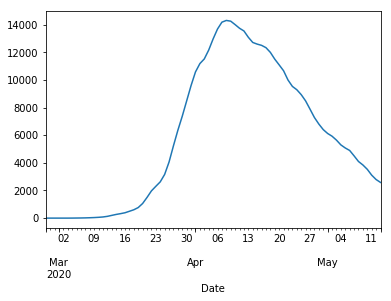

In [543]:
dataframe_new['Infected cases t-7'].plot()

# Fitting